In [ ]:
!pip install spectral
!pip install -U scikit-image

from spectral import *
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import pywt

from sklearn.decomposition import PCA

from skimage.color import rgb2lab
from skimage import io, color, img_as_float
from scipy.integrate import odeint


import os
from matplotlib.pyplot import imshow
import cv2
import random
from math import log
from google.colab.patches import cv2_imshow
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 8.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
!wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2023-04-12 12:10:41--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-04-12 12:10:42--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  3.12MB/s    in 1.8s    

2023-04-12 12:10:44 (3.12 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-04-12 12:10:44--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

In [ ]:
# Load the hyperspectral data
data_file = 'Indian_pines_corrected.mat'
data = sio.loadmat(data_file)['indian_pines_corrected']

# Print the shape of the data
print('Data shape:', data.shape) # Third attribute is the total number of bands

Data shape: (145, 145, 200)


In [ ]:
# Load the ground truth labels
labels_file = 'Indian_pines_gt.mat'
labels = sio.loadmat(labels_file)['indian_pines_gt']

# Print the shape of the labels
print('Labels shape:', labels.shape)

Labels shape: (145, 145)


In [ ]:
# Load the hyperspectral data
data_file = 'Indian_pines_corrected.mat'
data = sio.loadmat(data_file)['indian_pines_corrected']

In [ ]:
# Preprocess the data
X = data.reshape(-1, data.shape[-1])
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)
X_norm = (X_pca - np.min(X_pca)) / (np.max(X_pca) - np.min(X_pca))
X_norm = X_norm.reshape(data.shape[:-1] + (X_norm.shape[-1],))

In [ ]:
# Convert data to LAB color space and RGB color space
data_lab = color.rgb2lab(np.stack((X_norm[:,:,0],)*3, axis=-1))

In [ ]:
data_lab

array([[[ 6.66187522e+01, -1.74848192e-03,  3.31430905e-03],
        [ 6.82328895e+01, -1.78264232e-03,  3.37906129e-03],
        [ 6.87671830e+01, -1.79394972e-03,  3.40049485e-03],
        ...,
        [ 6.32755046e+01, -1.67772791e-03,  3.18019233e-03],
        [ 6.20372157e+01, -1.65152169e-03,  3.13051750e-03],
        [ 6.18121684e+01, -1.64675895e-03,  3.12148957e-03]],

       [[ 6.54594199e+01, -1.72394667e-03,  3.26780162e-03],
        [ 6.70850341e+01, -1.75834997e-03,  3.33301427e-03],
        [ 6.77900451e+01, -1.77327029e-03,  3.36129628e-03],
        ...,
        [ 6.87486392e+01, -1.79355727e-03,  3.39975095e-03],
        [ 6.84868943e+01, -1.78801789e-03,  3.38925087e-03],
        [ 6.71539923e+01, -1.75980935e-03,  3.33578058e-03]],

       [[ 6.65013232e+01, -1.74599674e-03,  3.30959830e-03],
        [ 6.70433254e+01, -1.75746727e-03,  3.33134110e-03],
        [ 6.76477696e+01, -1.77025928e-03,  3.35558880e-03],
        ...,
        [ 6.80930076e+01, -1.77968197e-03,

In [ ]:
type(data_lab)

numpy.ndarray

In [ ]:
data_lab.size

63075

In [ ]:
# Define the chaotic system (Lorenz system)
def lorenz_system(state, t, a, b, c):
    x, y, z = state
    dxdt = a*(y - x)
    dydt = x*(b - z) - y
    dzdt = x*y - c*z
    return [dxdt, dydt, dzdt]

In [ ]:
a, b, c= 10, 28, 8/3
timestep = 0.01
num_iterations = 10000
key = np.array([1, 2, 3]) # Replace with your own encryption key

In [ ]:
image_data_1d = data_lab.flatten()

# Apply encryption to each pixel in the image
for i in range(num_iterations):
    # Apply chaotic system to encryption key
    key = odeint(lorenz_system, key, [0, timestep], args=(a, b, c))[-1]

    # Use key to generate a new permutation of pixel indices
    perm = np.random.permutation(image_data_1d.shape[0])

   # Apply XOR encryption to each pixel value
for j in range(image_data_1d.shape[0]):
    pixel_value = np.round(image_data_1d[perm[j]]*255).astype(np.uint8)
    key_value = np.round(key*255).astype(np.uint8)
    encrypted_pixel = np.bitwise_xor(pixel_value, key_value)
    image_data_1d[perm[j]] = encrypted_pixel.astype(np.float32)[0]/255

# Reshape the encrypted image data into its original shape
encrypted_image_data = image_data_1d.reshape(data_lab.shape)

# Print the encrypted image
print(encrypted_image_data)

[[[0.20392157 0.40784314 0.41176471]
  [0.62352941 0.40784314 0.41176471]
  [0.90980392 0.40784314 0.41176471]
  ...
  [0.43529412 0.40784314 0.41176471]
  [0.63921569 0.40784314 0.41176471]
  [0.98039216 0.40784314 0.41176471]]

 [[0.36078431 0.40784314 0.41176471]
  [0.73333333 0.40784314 0.41176471]
  [0.93333333 0.40784314 0.41176471]
  ...
  [0.0745098  0.40784314 0.41176471]
  [0.31372549 0.40784314 0.41176471]
  [0.54901961 0.40784314 0.41176471]]

 [[0.3372549  0.40784314 0.41176471]
  [0.62745098 0.40784314 0.41176471]
  [0.03921569 0.40784314 0.41176471]
  ...
  [0.7372549  0.40784314 0.41176471]
  [0.42745098 0.40784314 0.41176471]
  [0.68235294 0.40784314 0.41176471]]

 ...

 [[0.09803922 0.40784314 0.40784314]
  [0.36470588 0.40784314 0.40784314]
  [0.3372549  0.40784314 0.40784314]
  ...
  [0.18823529 0.40784314 0.40784314]
  [0.44705882 0.40784314 0.41176471]
  [0.88235294 0.40784314 0.40784314]]

 [[0.97647059 0.40784314 0.40784314]
  [0.3254902  0.40784314 0.40784314]


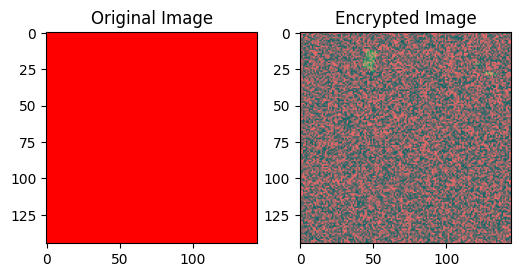

In [ ]:
import matplotlib.pyplot as plt

# Display the original image and the encrypted image side by side
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(data_lab)
ax[0].set_title('Original Image')
ax[1].imshow(encrypted_image_data)
ax[1].set_title('Encrypted Image')
plt.show()

In [ ]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.metrics import normalized_root_mse as image_fidelity

# Calculate metrics
mse = mean_squared_error(data_lab, encrypted_image_data)
psnr = peak_signal_noise_ratio(data_lab, encrypted_image_data, data_range=data_lab.max() - data_lab.min())
ifd = image_fidelity(data_lab, encrypted_image_data)

# Print metrics - lower MSE and higher PSNR, IFD indicate better encryption quality
print(f"MSE: {mse:.2f}")
print(f"PSNR: {psnr:.2f}")
print(f"IFD: {ifd:.2f}")

MSE: 961.76
PSNR: 9.16
IFD: 0.99
